#### Importowanie potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

#### Wczytanie pliku csv i sprawdzenie informacji o typach danych i wartościach null używając funkcji info

In [2]:
data = pd.read_parquet('data_cleaned.parquet')
data
print(data.info())
data.head()
data = data[data['UnitPrice'] > 0]
data = data[data['Quantity'] > 0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537966 entries, 0 to 537970
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    537966 non-null  object        
 1   StockCode    537966 non-null  object        
 2   Description  537966 non-null  object        
 3   Quantity     537966 non-null  int64         
 4   InvoiceDate  537966 non-null  datetime64[ns]
 5   UnitPrice    537966 non-null  float64       
 6   CustomerID   405542 non-null  float64       
 7   Country      537966 non-null  object        
 8   ItemTotal    537966 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 41.0+ MB
None


In [3]:
start_date = data["InvoiceDate"].max() + pd.DateOffset(1)
data["Total_sales"] = data["UnitPrice"] * data["Quantity"]
data_rfm = data.groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (start_date - x.max()).days,
'InvoiceNo': 'count','Total_sales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','Total_sales': 'Monetary'})


In [4]:
data_rfm['R_score'] = pd.qcut(data_rfm['Recency'], 4, labels=False)
data_rfm['F_score'] = pd.qcut(data_rfm['Frequency'], 4, labels=False)
data_rfm['M_score'] = pd.qcut(data_rfm['Monetary'], 4, labels=False)

data_rfm['R_score'] = 3 - data_rfm['R_score']

data_rfm["RFM_Score"] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']

                ----------------- Krzywa rozkładu for R,F,M -------------------------------


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

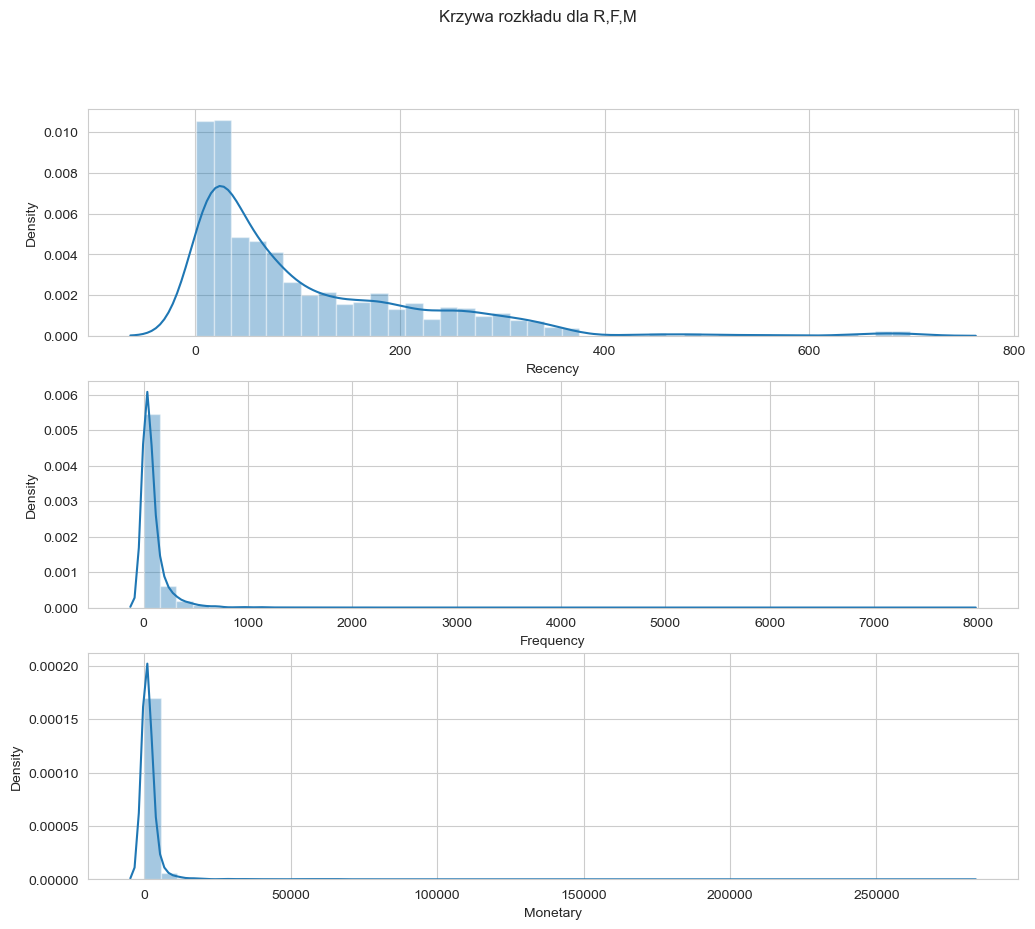

In [5]:
print("                ----------------- Krzywa rozkładu for R,F,M -------------------------------")

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))
plt.suptitle('Krzywa rozkładu dla R,F,M')
# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data_rfm['Recency'])
# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data_rfm['Frequency'])
# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data_rfm['Monetary'])

In [6]:
data_rfm

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12347.0,41,182,4310.00,2,3,3,8
1,12348.0,77,27,1437.24,1,1,2,4
2,12349.0,20,72,1457.55,3,2,2,7
3,12350.0,312,16,294.40,0,0,0,0
4,12352.0,74,80,2226.04,1,2,3,6
...,...,...,...,...,...,...,...,...
4331,18280.0,161,10,180.60,1,0,0,1
4332,18281.0,5,7,80.82,3,0,0,3
4333,18282.0,217,12,178.05,0,0,0,0
4334,18283.0,11,756,2094.88,3,3,3,9


In [7]:
from scipy.stats import shapiro
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

transformations = {
    'Pierwiastek kwadratowy': np.sqrt,
    'Logarytmiczna': np.log,
    'Logarytmiczna przesunięta': np.log1p,
}

best_transformation = None
best_score = -np.inf

for name, transformation in transformations.items():
    data = data_rfm.copy()
    transformer = ColumnTransformer(transformers=[("transformer", FunctionTransformer(transformation), ['Recency', 'Frequency', 'Monetary'])])
    transformed_data = pd.DataFrame(transformer.fit_transform(data[['Recency', 'Frequency', 'Monetary']]))
    shapiro_w, _ = shapiro(transformed_data)
    if shapiro_w > best_score:
        best_score = shapiro_w
        best_transformation = name

print(best_transformation, best_score)


Logarytmiczna 0.9971605539321899


In [8]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

logTr = ColumnTransformer(transformers=[("transformer", FunctionTransformer(np.log), ['Recency', 'Frequency', 'Monetary'])])
data_rfm[['log_R', 'log_F', 'log_M']] = pd.DataFrame(logTr.fit_transform(data_rfm[['Recency', 'Frequency', 'Monetary']]))




                ----------------- Log Transformation Plots for R,F,M -------------------------------


<AxesSubplot:xlabel='log_M', ylabel='Density'>

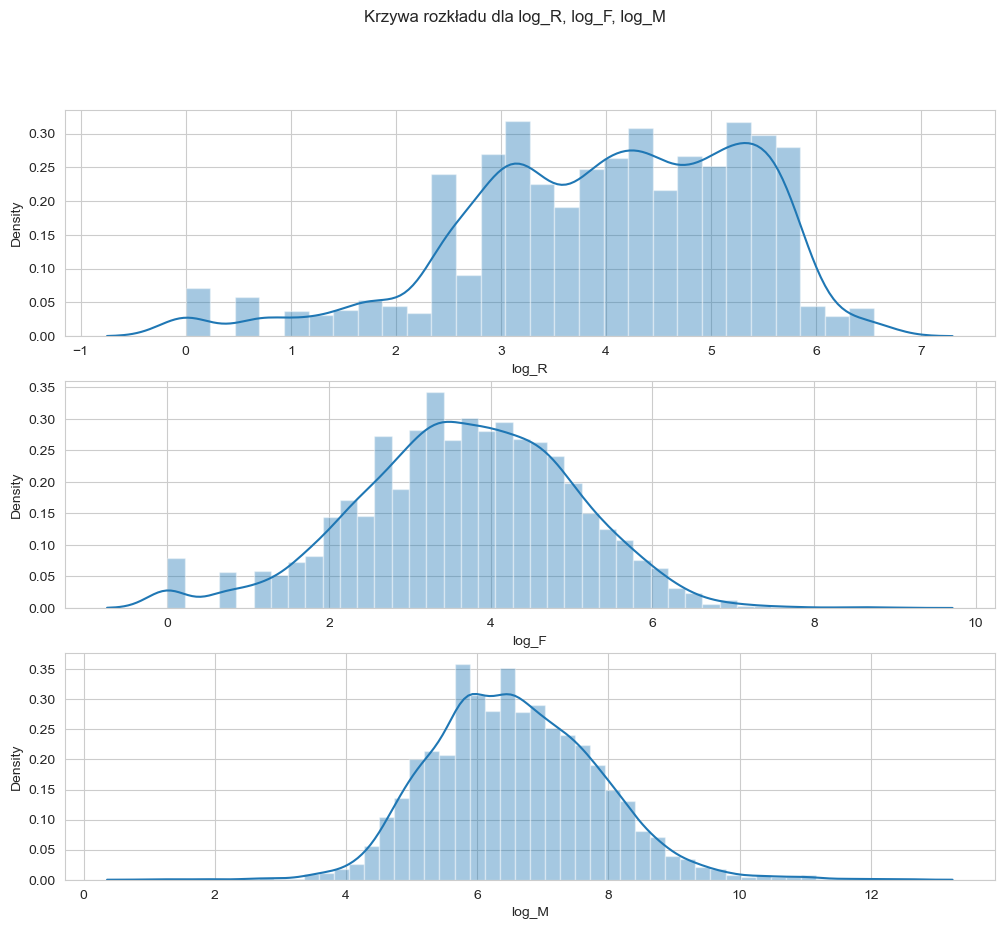

In [9]:

print("                ----------------- Log Transformation Plots for R,F,M -------------------------------")
plt.figure(figsize=(12,10))
plt.suptitle('Krzywa rozkładu dla log_R, log_F, log_M')
plt.subplot(3, 1, 1)
sns.distplot(data_rfm['log_R'])
plt.subplot(3, 1, 2)
sns.distplot(data_rfm['log_F'])
plt.subplot(3, 1, 3)
sns.distplot(data_rfm['log_M'])